In [78]:
# Library imports
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [79]:
def normalize_minmax(data):
    data = (data - data.min(axis=0)) / (data.max(axis=0) - data.min(axis=0))
    return data

def prob(betas, data, i):
    rows, cols = data.shape
    u = betas[0] + np.dot(betas[1:], data[i][:cols - 1].T)
    return 1 / (1 + math.exp(-u))

def log_loss(betas, data):
    rows, cols = data.shape
    loss = 0
    for i in range(rows):
        cli = data[i][cols - 1]
        pi = prob(betas, data, i)
        loss += cli * math.log(pi) + (1 - cli) * math.log(1 - pi)
    loss *= -1 / rows
    return loss

def iterate(betas, data, epochs, learning_rate):
    errors = [log_loss(betas, data)]
    rows, cols = data.shape
    for k in range(epochs):
        dbetas = np.zeros(len(betas))
        for i in range(rows):
            u = betas[0] + np.dot(betas[1:], data[i][:cols - 1].T)
            temp = prob(betas, data, i) * (data[i][cols - 1] * math.exp(-u) + data[i][cols - 1] - 1)
            dbetas[0] += temp
            dbetas[1:] += data[i][:cols - 1] * temp
        dbetas *= -1 / rows
        betas -= dbetas * learning_rate
        errors.append(log_loss(betas, data))
    return errors

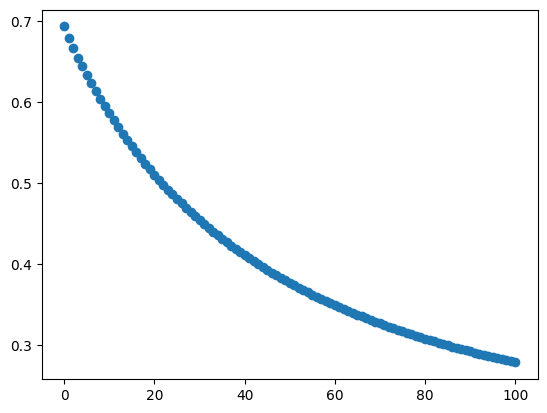

In [86]:
data = pd.read_csv('data.csv').to_numpy()
data = normalize_minmax(data)

betas = np.zeros(data.shape[1])

eps = 100
lr = 1
errors = iterate(betas, data, eps, lr)

plt.scatter(x=range(eps + 1), y=errors)
plt.show()

In [83]:
cars = pd.read_csv('car_data.csv')
cars = cars[['Gender', 'Age', 'AnnualSalary', 'Purchased']]
cars = cars.transform(lambda x: (x == 'Male') * 1 if x.name == 'Gender' else x)
cars = normalize_minmax(cars.to_numpy())
print(cars)

[[1.         0.37777778 0.03636364 0.        ]
 [1.         0.48888889 0.20727273 0.        ]
 [1.         0.68888889 0.42909091 0.        ]
 ...
 [0.         0.22222222 0.89818182 1.        ]
 [0.         0.66666667 0.86545455 1.        ]
 [0.         0.57777778 0.42545455 0.        ]]


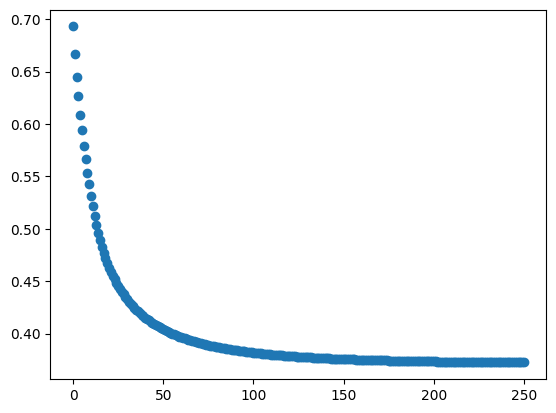

In [94]:
betas = np.zeros(cars.shape[1])

eps = 250
lr = 5
errors = iterate(betas, cars, eps, lr)

plt.scatter(x=range(eps + 1), y=errors)
plt.show()